# InitialsGAN
```GAN 04 - Adjustable GAN with UI ```

* Used PR Castro's repository for reference for basis of the GAN: https://github.com/prcastro/pytorch-gan
* Used Yun Chen's repository for reference for conversion to DCGAN and WGAN: https://github.com/chenyuntc/pytorch-GAN
* Used Mamy Ratsimbazafy's comment for reference for save/load of the model: https://discuss.pytorch.org/t/saving-and-loading-a-model-in-pytorch/2610

In [1]:
import UI
UI.Show()

### Set model parameters:

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

\* Only relevant in case of use of Wasserstein distance.

In [3]:
UI.PrintModelSettings()

#### Please check your settings:

ConvolutionalGAN, BCE loss, Adam optimizer, BatchNorm, batchsize of 32, learning rate of 0.0002, beta1 of 0.5, for 25 epochs.


#### Results to be saved at:

Z:/GAN-Training-Results/TestOutput/


In [4]:
UI.showrunmodelbutton()

A Jupyter Widget

* Runs all the cells below


### Importing libraries and dataset

In [5]:
# import the dataset class (64x64 images)
import dataset02 as dataset

# python imports
import itertools
import math
import time
import os
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import numpy as np

# pytorch imports
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as tf
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import RMSprop
from scipy.spatial import distance

### Retrieve parameters

In [6]:
# Get the settings from the buttons above
loss = UI.loss.value
optimization = UI.optim.value
normalization = UI.norm.value
batchsize = int(UI.batch.value)
num_epochs = UI.epochs.value
lr = UI.lrate.value # learning rate
beta1 = UI.beta1.value 
clamp_num = UI.clamp.value # WGAN clip gradient

# Save path for results
savepath = UI.savepath.value

In [8]:
# This opens the HDF5 database and allows us to query it
data = dataset.get_dataset()
print("there are", len(data), "images in this dataset")

there are 30650 images in this dataset


### Creating a dataloader 

In [9]:
# Setting threads (num_workers) to 0 as suggested at https://discuss.pytorch.org/t/dataloader-iteration-hang-up/12886/3
threads = 0 # can increase this to have more data preloading, useful if your CPU cant keep up with GPU
shuffle = True # Shuffles the dataset before loading batches
cuda = True

train_loader = DataLoader(dataset=data, num_workers=threads, batch_size=batchsize, shuffle=shuffle, pin_memory=cuda)

### Other parameters

In [10]:
# 'Hardcoded' for the initials dataset
start_epoch = 0 # unless overwritten later by checkpoint loading
noisedim = 100 # noise dimension
image_size = 64
image_size2 = 64
nc = 1 # channel of img 
ngf = 64 # generate channel
ndf = 64 # discriminative channel

# Show the number of batches
num_batches = len(train_loader)
print('There are ' + str(num_batches) + ' batches')

There are 958 batches


### Model set-up

In [11]:
# Conditionally set the normalization
if(normalization == 'BatchNorm'):
    gnormlayer0 = nn.BatchNorm2d(ngf)
    gnormlayer1 = nn.BatchNorm2d(ngf*2)
    gnormlayer2 = nn.BatchNorm2d(ngf*4)
    gnormlayer3 = nn.BatchNorm2d(ngf*8)
    
    dnormlayer0 = nn.BatchNorm2d(ndf)
    dnormlayer1 = nn.BatchNorm2d(ndf*2)
    dnormlayer2 = nn.BatchNorm2d(ndf*4)
    dnormlayer3 = nn.BatchNorm2d(ndf*8)
elif(normalization == 'InstanceNorm'):
    gnormlayer0 = nn.InstanceNorm2d(ngf)
    gnormlayer1 = nn.InstanceNorm2d(ngf*2)
    gnormlayer2 = nn.InstanceNorm2d(ngf*4)
    gnormlayer3 = nn.InstanceNorm2d(ngf*8)
    
    dnormlayer0 = nn.InstanceNorm2d(ndf)
    dnormlayer1 = nn.InstanceNorm2d(ndf*2)
    dnormlayer2 = nn.InstanceNorm2d(ndf*4)
    dnormlayer3 = nn.InstanceNorm2d(ndf*8)
else: 
    raise ValueError('The currently set normalization option (\'' + normalization + '\') cannot be used.')

In [12]:
# Conditionally set up the final layer of discriminator net
if(loss == 'Wasserstein'):
    discriminator = nn.Sequential(
        nn.Conv2d(nc,ndf,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
        dnormlayer1,
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
        dnormlayer2,
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
        dnormlayer3,
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*8,1,4,1,0,bias=False),
        # For WGAN we remove the sigmoid function
        # nn.Sigmoid()
    ).cuda()
else:
    discriminator = nn.Sequential(
        nn.Conv2d(nc,ndf,4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf,ndf*2,4,2,1,bias=False),
        dnormlayer1,
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*2,ndf*4,4,2,1,bias=False),
        dnormlayer2,
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*4,ndf*8,4,2,1,bias=False),
        dnormlayer3,
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*8,1,4,1,0,bias=False),
        nn.Sigmoid()
    ).cuda()

In [13]:
generator= nn.Sequential(
        nn.ConvTranspose2d(noisedim,ngf*8,4,1,0,bias=False),
        gnormlayer3,
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*8,ngf*4,4,2,1,bias=False),
        gnormlayer2,
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*4,ngf*2,4,2,1,bias=False),
        gnormlayer1,
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf*2,ngf,4,2,1,bias=False),
        gnormlayer0,
        nn.ReLU(True),

        nn.ConvTranspose2d(ngf,nc,4,2,1,bias=False),
        nn.Tanh()
    ).cuda()

### Weigth initialization

In [14]:
if(loss == 'Wasserstein'):
    def weight_init(m):
        class_name=m.__class__.__name__
        if class_name.find('Conv')!=-1:
            m.weight.data.normal_(0,0.02)
        elif class_name.find('Norm')!=-1:
            m.weight.data.normal_(1.0,0.02)

    discriminator.apply(weight_init)
    generator.apply(weight_init)

### Criterion

In [15]:
if(loss == 'BCE'):
    criterion = nn.BCELoss()

### Optimizer

In [16]:
if(optimization == 'Adam'):
    d_optimizer = torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(beta1,0.999))
    g_optimizer = torch.optim.Adam(generator.parameters(),lr=lr,betas=(beta1,0.999))
elif(optimization == 'RMSprop'):
    d_optimizer = RMSprop(discriminator.parameters(), lr=lr)
    g_optimizer = RMSprop(generator.parameters(), lr=lr)
else:
    raise ValueError('The currently set optimization option (\'' + optimization + '\') cannot be used.')

### Training

In [17]:
# Necessary for training
if(loss == 'Wasserstein'):
    one = torch.FloatTensor([1])
    mone = -1*one
    one = one.cuda()
    mone = mone.cuda()

In [18]:
def train_discriminator(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    if(loss == 'BCE'):
        real_loss = criterion(outputs, real_labels)
        real_score = outputs
    elif(loss == 'Wasserstein'):
        outputs.backward(one)
    
    outputs = discriminator(fake_images)
    if(loss == 'BCE'):
        fake_loss = criterion(outputs, fake_labels)
        fake_score = outputs
        d_loss = real_loss + fake_loss
        d_loss.backward()
    elif(loss == 'Wasserstein'):
        outputs.backward(mone)
    
    d_optimizer.step()

In [19]:
def train_generator(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    if(loss == 'BCE'):
        g_loss = criterion(discriminator_outputs, real_labels)
        g_loss.backward()
    elif(loss == 'Wasserstein'):
        discriminator_outputs.backward(one)
    g_optimizer.step()

In [20]:
# draw samples from the input distribution to inspect the generation on training 
num_test_samples = 25
fix_noise = Variable(torch.FloatTensor(num_test_samples, noisedim, 1, 1).normal_(0,1)).cuda()

### Save and load model checkpoints

In [21]:
# Function to save the current state
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    saveloc = savepath + filename
    torch.save(state, saveloc)
    print('-- Checkpoint saved --')

In [22]:
# Function to load model (either a fully trained model or in progress model)
def load_checkpoint():
    cp_path = savepath + 'checkpoint.pth.tar'
    if os.path.isfile(cp_path):
        print('Loading checkpoint...')
        # load the data
        checkpoint = torch.load(cp_path)
        # set starting epoch
        global start_epoch 
        start_epoch = checkpoint['epoch']
        # load the states of the models and optimizers
        generator.load_state_dict(checkpoint['g_state'])
        discriminator.load_state_dict(checkpoint['d_state'])
        g_optimizer.load_state_dict(checkpoint['g_optim'])
        d_optimizer.load_state_dict(checkpoint['d_optim'])
        print('Checkpoint successfully loaded')
        # load the used noise
        global fix_noise
        fix_noise = checkpoint['noise']
    else:
        print('No checkpoint to load, starting training from scratch.')

### Execute training and sampling

In [23]:
def img_to_numpy(image):
    return image.data.cpu().numpy().flatten()

In [24]:
def generate_output(num_output, noise, foldername, perform_eval):
    output = generator(noise)
    saveloc = savepath + foldername
    
    # Make a new folder if there ins't one yet
    if not os.path.exists(saveloc):
        os.makedirs(saveloc)
        
    for k in range(num_output):
        vutils.save_image(output[k,:].data, saveloc + '/image-' + str(k+1) + '.png')
        if(perform_eval):
            print('Starting NN search for output ' + str(k) + ' ...')
            output_array = img_to_numpy(output[k,:])
            # perform the NN search
            nearest, dist = getnearestneighbor(output_array, data)
            # Save the nearest neighbor image in the same folder
            vutils.save_image(torch.from_numpy(data[nearest][0].numpy().squeeze()), saveloc + '/neighbor-' + str(k+1) + '-' + str(nearest) + '.png')
            print('Done')
            
    print('Saved output to ' + saveloc)

In [28]:
def getnearestneighbor(output_array, dataset):
    # Initialize the nearest neighbor to be the first from the dataset
    nearest = 0
    nearest_dist = distance.euclidean(output_array, dataset[0][0].numpy().flatten())
   
    # Loop through dataset to find the nearest one
    for i, datapoint in enumerate(dataset):
        if(i<(len(dataset)-1)):
            dataset_array = datapoint[0].numpy().flatten()
            dist = distance.euclidean(output_array, dataset_array)
            if(dist < nearest_dist):
                nearest_dist = dist
                nearest = i 
        else:
            return nearest, nearest_dist
   
    return nearest, nearest_dist

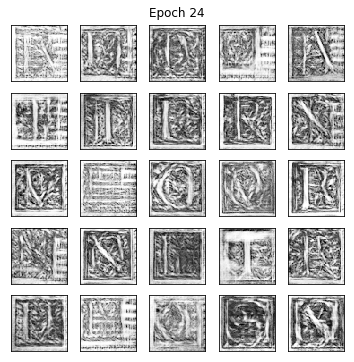

Epoch [24/25], Step[950/958]


C:\Users\Corine\Anaconda3\lib\site-packages\torch\nn\functional.py:1168: UserWarning: Using a target size (torch.Size([26])) that is different to the input size (torch.Size([26, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


-- Checkpoint saved --
Starting NN search for output 0 ...
Done
Starting NN search for output 1 ...
Done
Starting NN search for output 2 ...
Done
Starting NN search for output 3 ...
Done
Starting NN search for output 4 ...
Done
Starting NN search for output 5 ...


KeyboardInterrupt: 

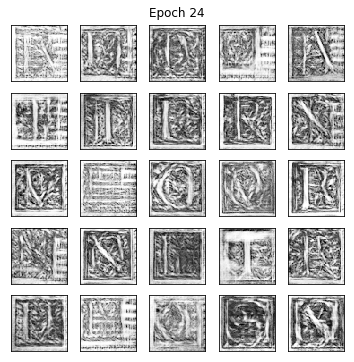

In [29]:
# create figure for plotting
size_figure_grid = int(math.sqrt(num_test_samples))
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(6, 6))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i,j].get_xaxis().set_visible(False)
    ax[i,j].get_yaxis().set_visible(False)

# Save the model settings to the save location
f = open(savepath + "modelsettings.txt", "w+")
f.write(UI.GetFormattedSettings())
f.close()

# Load checkpoint if one if available
load_checkpoint()

for epoch in range(start_epoch, num_epochs):
    print('Working on epoch ' + str(epoch+1) + ' ...')
    for n, (images, letters, countries, cities, names) in enumerate(train_loader):
        images = Variable(images).cuda()
        real_labels = Variable(torch.ones(images.size(0)).cuda())
        
        # Generate the noise
        noise = torch.randn(images.size(0),noisedim,1,1)
        noise = Variable(noise).cuda()
        
        # clip paramaters for discriminator (only for wasserstein)
        if(loss == 'Wasserstein'):
            for parameter in discriminator.parameters():
                parameter.data.clamp_(-clamp_num, clamp_num)
        
        # Sample from generator using the noise
        fake_images = generator(noise)
        fake_labels = Variable(torch.zeros(images.size(0)).cuda())
        
        # Train the discriminator
        train_discriminator(discriminator, images, real_labels, fake_images, fake_labels)
        
        # Sample again from the generator and get output from discriminator
        noise = torch.randn(images.size(0),noisedim,1,1)
        noise = Variable(noise).cuda()
        
        fake_images = generator(noise)
        outputs = discriminator(fake_images)
        
        # Train the generator more often for wasserstein
        if (loss == 'Wasserstein'):
            if (n+1)%5 == 0:
                train_generator(generator, outputs, real_labels)
                if n%100: pass
        elif (loss == 'BCE'):
            train_generator(generator, outputs, real_labels)
        
        # For every hundred batches show and save a plot of output
        if (n+1) % 190 == 0:
            step = 0
            test_images = generator(fix_noise)
            
            for k in range(num_test_samples):
                i = k//5
                j = k%5
                ax[i,j].cla()
                ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(64, 64), cmap='gray')
            display.clear_output(wait=True)
            plt.title("Epoch " + str(epoch+1), y=5.85, x=-1.98)
            display.display(plt.gcf())
            
            plt.savefig(savepath + 'result_' + str(epoch+1) + '-' + str(n+1) + '.png')
            step += 1
            
            print('Epoch [%d/%d], Step[%d/%d]' 
                  %(epoch+1, num_epochs, n+1, num_batches))
         
    # Make a save of the current state of the model and optimizers
    save_checkpoint({
        'epoch': (epoch+1),
        'g_state': generator.state_dict(),
        'd_state': discriminator.state_dict(),
        'g_optim' : g_optimizer.state_dict(),
        'd_optim' : d_optimizer.state_dict(),
        'noise' : fix_noise
    })

    # For each epoch save a set of output images in a seperate folder 
    perform_eval = True
    generate_output(25, fix_noise, 'output', perform_eval)
